# Data Anlysis

This data analysis is performed on the simple sensor data measuring power consumption. 

In [1]:
# Import required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read data from json file to pandas dataframe
df = pd.read_json("data.json")

In [3]:
# convert timestamp to datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [4]:
# basic information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49901 entries, 0 to 49900
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   machine_id       49901 non-null  int64         
 1   timestamp        49901 non-null  datetime64[ns]
 2   sensor_id        49901 non-null  int64         
 3   consumption_kwh  49901 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 1.5 MB


In [5]:
df = df.drop(["machine_id","sensor_id"], axis=1)

the above line removes machine_id and sensor_id from the dataframe which are not required for the analysis as they are the same for each row.

In [6]:
df.describe()

,timestamp,consumption_kwh
count,49901,49901.000000
mean,2023-01-01 05:57:23.649446144,3.761814
min,2022-12-31 23:00:01,-1.000000
25%,2023-01-01 02:29:35,2.764076
50%,2023-01-01 05:57:30,4.006564
75%,2023-01-01 09:25:25,5.000000
max,2023-01-01 12:53:20,16.000000
std,NaN,1.216318


## Distribution of 'consumption_kwh'

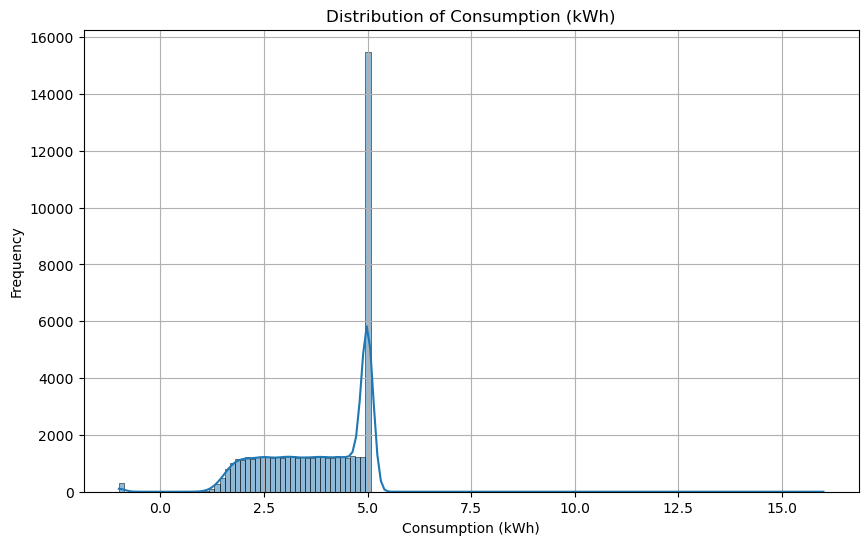

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df['consumption_kwh'], kde=True)
plt.title('Distribution of Consumption (kWh)')
plt.xlabel('Consumption (kWh)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

We can see two abnormalities in the data. The first one is a negative value for 'consumption_kwh' and the second one is a value of 0.0. We will remove these two values from the dataset. 

## Time Series Plot

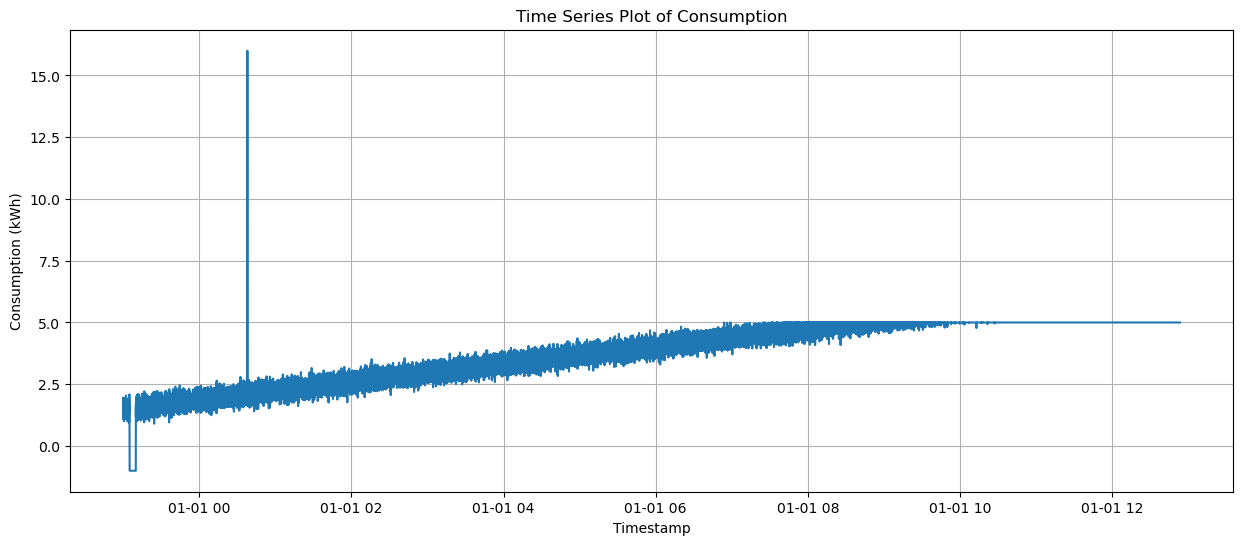

In [8]:
plt.figure(figsize=(15, 6))
sns.lineplot(x='timestamp', y='consumption_kwh', data=df)
plt.title('Time Series Plot of Consumption')
plt.xlabel('Timestamp')
plt.ylabel('Consumption (kWh)')
plt.grid(True)
plt.show()

This plot shows the outliers position in the time series. We can see that the first outlier is at the beginning of the time series and the second one is just an hour after it. They don't seem to be related to each other or caused by any particular event.

## Box Plot Consumption_kwh

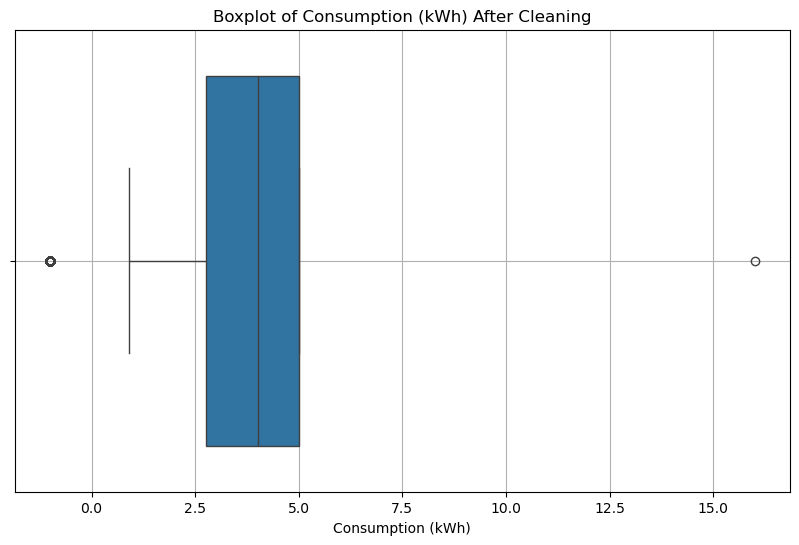

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['consumption_kwh'])
plt.title('Boxplot of Consumption (kWh) After Cleaning')
plt.xlabel('Consumption (kWh)')
plt.grid(True)
plt.show()

Above box plot shows that there are outliers in the data. one outlier on the right extreme and the other two in the left. We will remove them in the next step.

In [10]:
# Assuming any consumption value below 0 is an error and should be set to NaN
df['consumption_kwh'] = df['consumption_kwh'].apply(lambda x: x if x >= 0 else None)

# Identifying outliers using the Interquartile Range (IQR) method
Q1 = df['consumption_kwh'].quantile(0.25)
Q3 = df['consumption_kwh'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering out the outliers
df_clean = df[(df['consumption_kwh'] >= lower_bound) & (df['consumption_kwh'] <= upper_bound)]

df_clean.describe()

,timestamp,consumption_kwh
count,49601,49601.000000
mean,2023-01-01 05:59:52.282857472,3.790272
min,2022-12-31 23:00:01,0.902245
25%,2023-01-01 02:33:20,2.787579
50%,2023-01-01 06:00:00,4.024342
75%,2023-01-01 09:26:40,5.000000
max,2023-01-01 12:53:20,5.000000
std,NaN,1.160973


Above table shows the summary of the data after removing the outliers, which were identified through interquartile range method. we can see that the mean and median did not change much after removing the outliers. 

## Time Series plot of the clean data

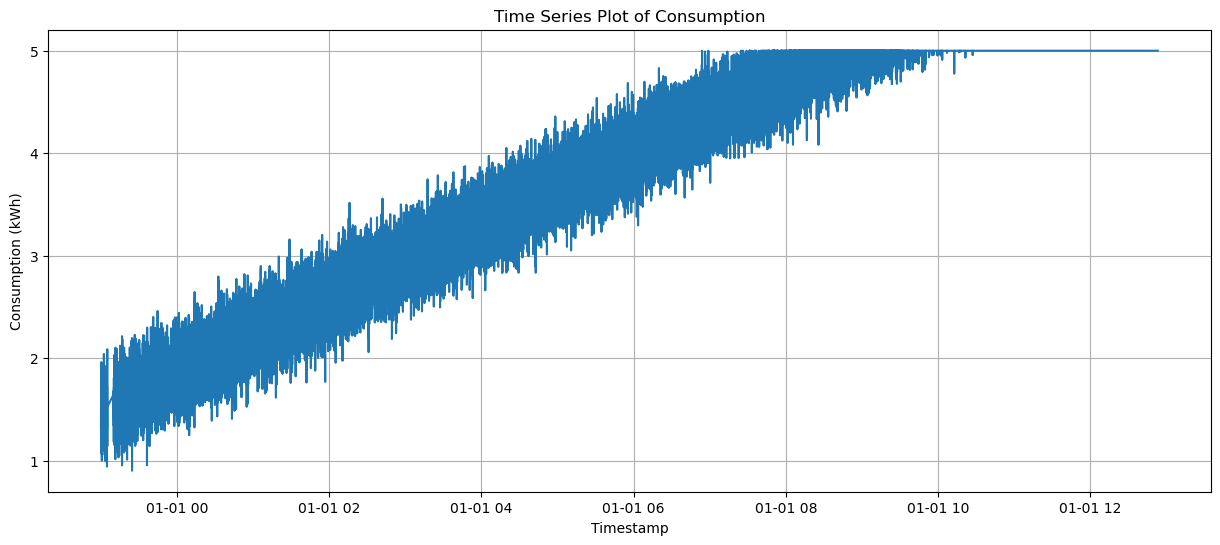

In [11]:
plt.figure(figsize=(15, 6))
sns.lineplot(x='timestamp', y='consumption_kwh', data=df_clean)
plt.title('Time Series Plot of Consumption')
plt.xlabel('Timestamp')
plt.ylabel('Consumption (kWh)')
plt.grid(True)
plt.show()

This graph shows there are no outliers in the data and the data varies from 0 to 5 kwh.

## Rolling Average of Consumption (Trend Analysis)

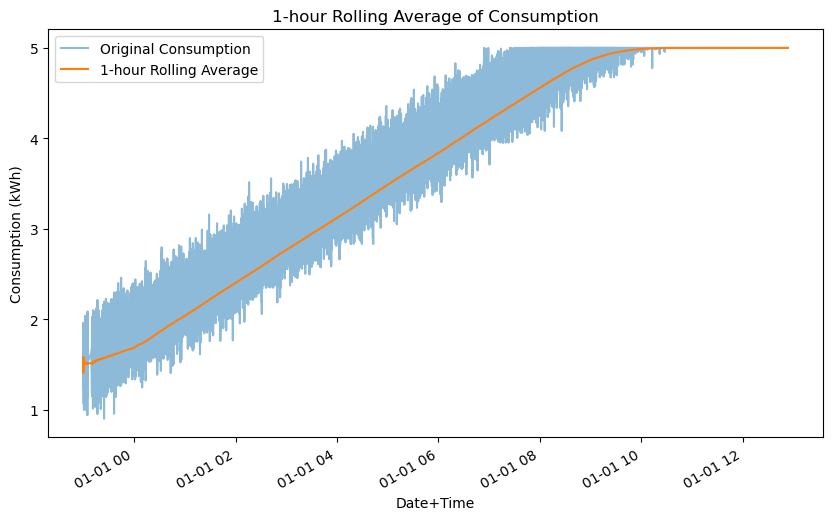

In [12]:
df_new = df_clean.copy()
df_clean.set_index("timestamp", inplace=True)

# Plot original consumption data
df_clean["consumption_kwh"].plot(figsize=(10, 6), label='Original Consumption', alpha=0.5)

# Calculate and plot 1-hour rolling average
df_clean["consumption_kwh"].rolling('60T').mean().plot(label='1-hour Rolling Average')

# Set plot title and labels
plt.title('1-hour Rolling Average of Consumption')
plt.ylabel('Consumption (kWh)')
plt.xlabel('Date+Time')

# Add legend to distinguish between original and rolling average
plt.legend()

# Display the plot
plt.show()


This graph shows hourly rolling average of the power consumption. All the analysis represents that the data has a simple growing pattern from 31 Dec 2022 night 23:00 to 01 Jan 2023 12:00. So at the mid of the night the power consumption is the lowest and at the mid of the day the powerconsumption is maximum. 

9:00 to 13:00 on 1st of Jan 2023 the energy consumption is near the maximum value over the complete dataset.

We can try plotting graphs for each hour to see more detailed behaviour.

In [13]:
# Extract hour from the timestamp
df_new["hour"] = df_new["timestamp"].dt.hour

In [14]:
# Group by hour
grouped_data = df_new.groupby("hour")

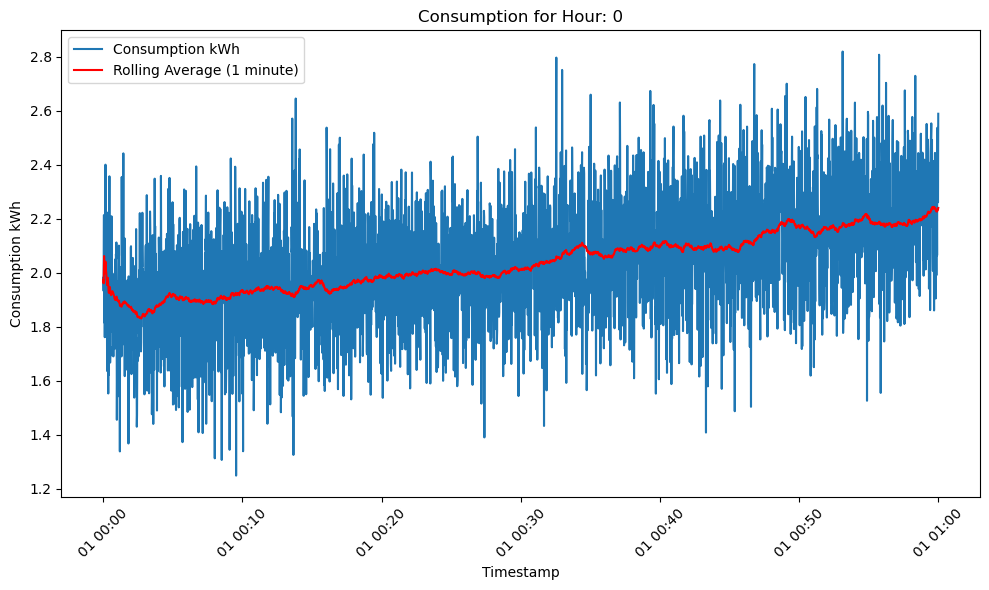

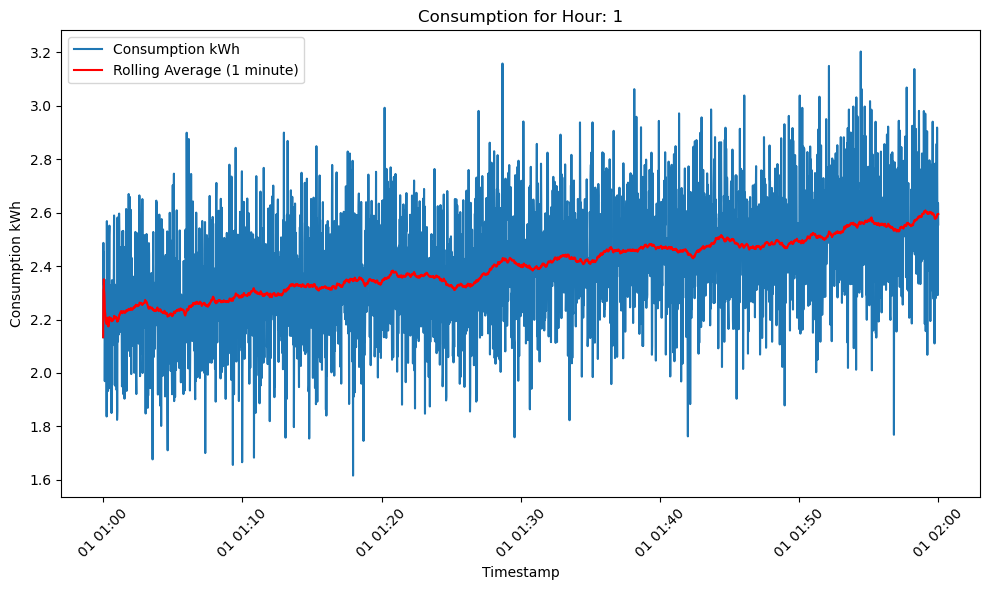

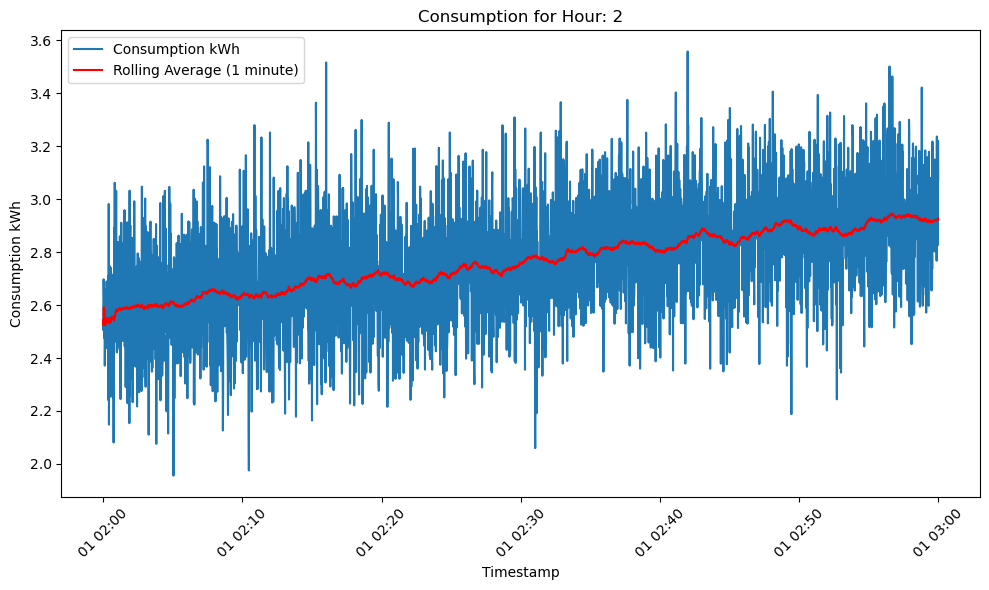

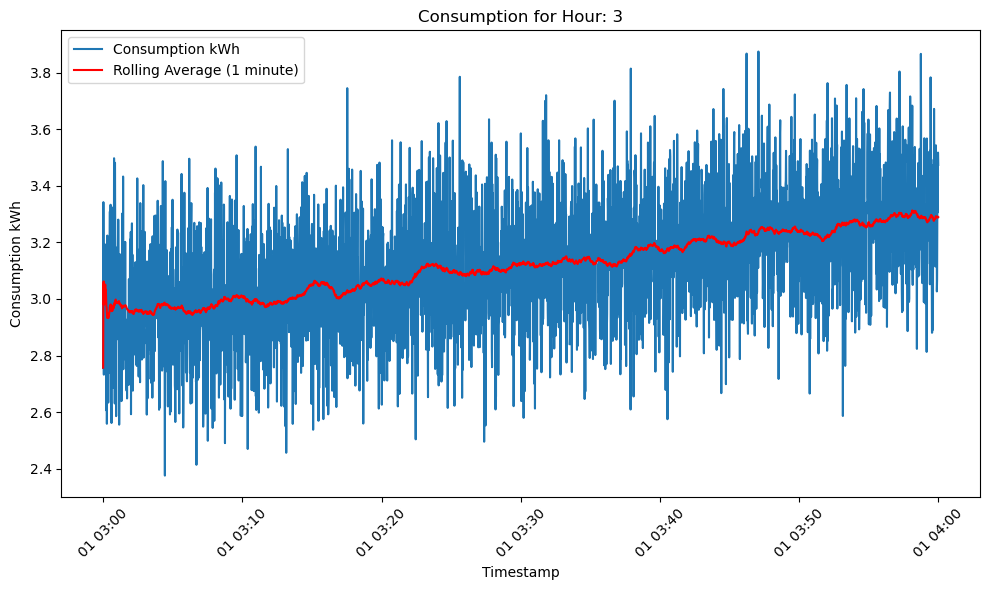

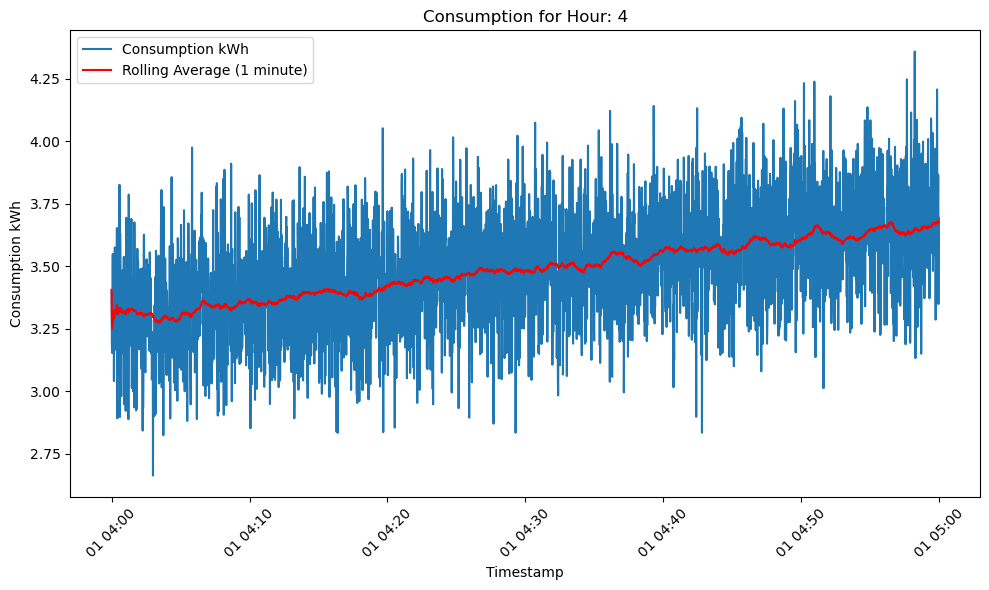

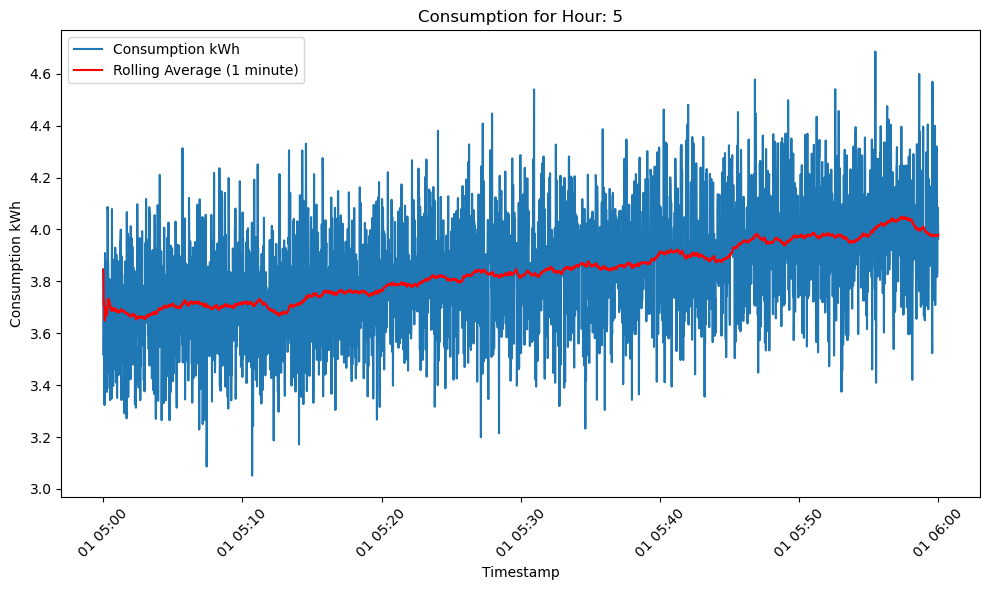

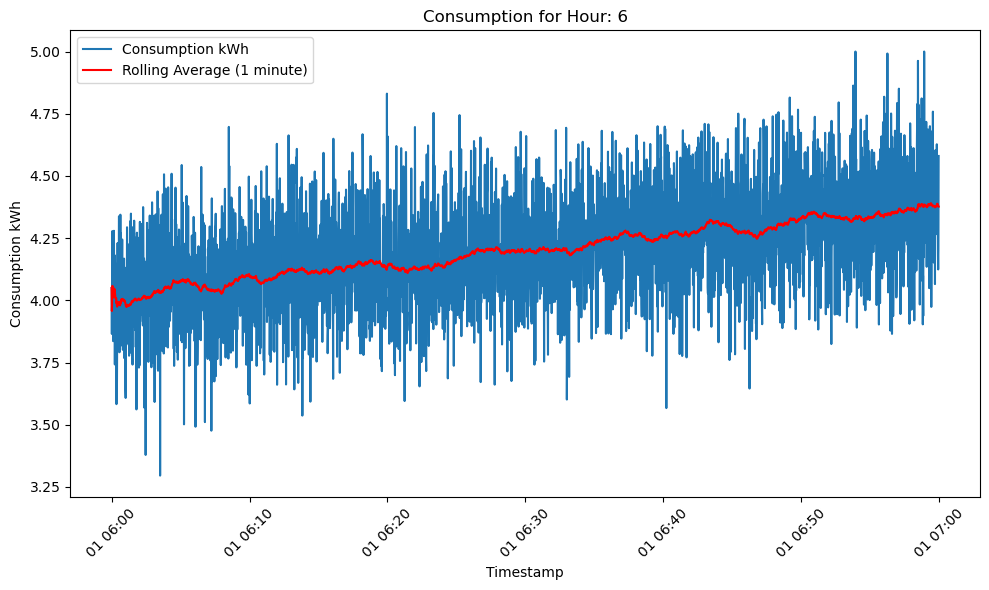

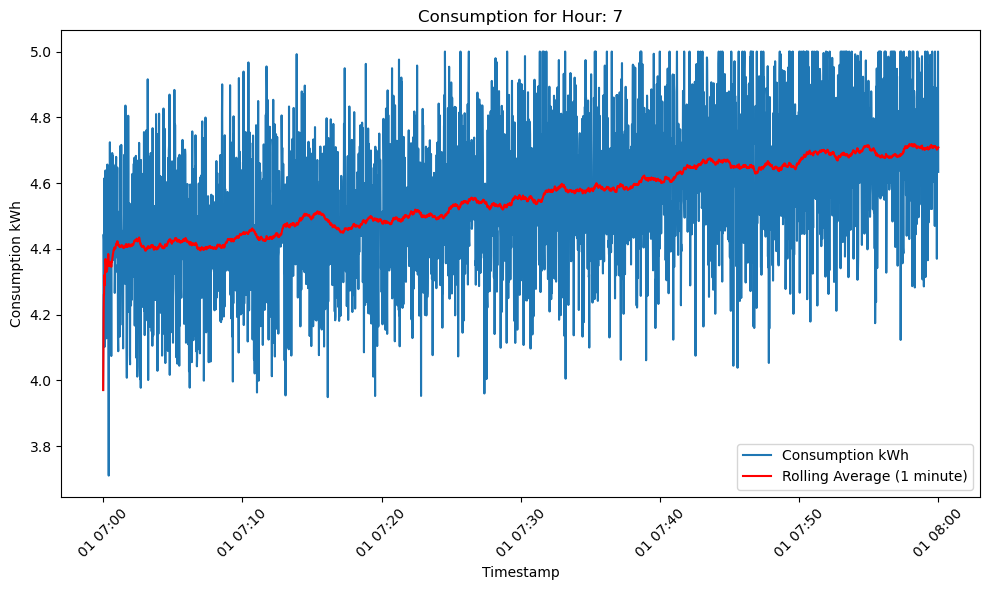

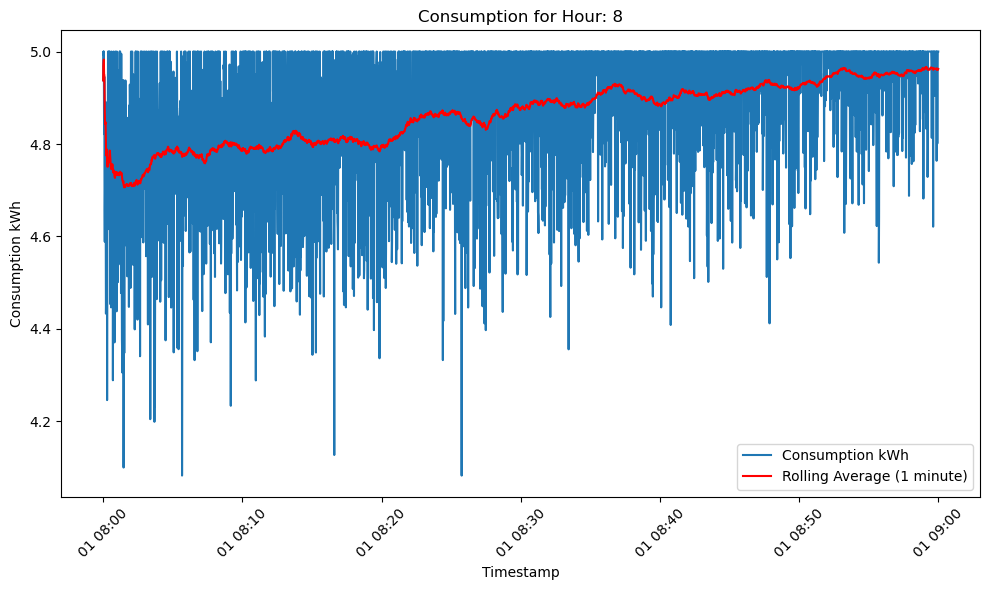

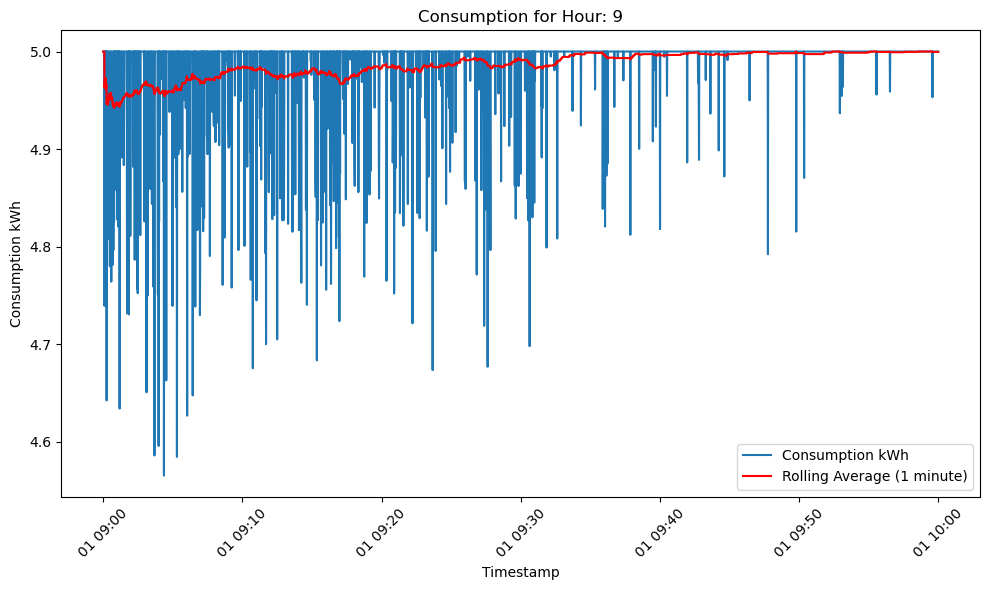

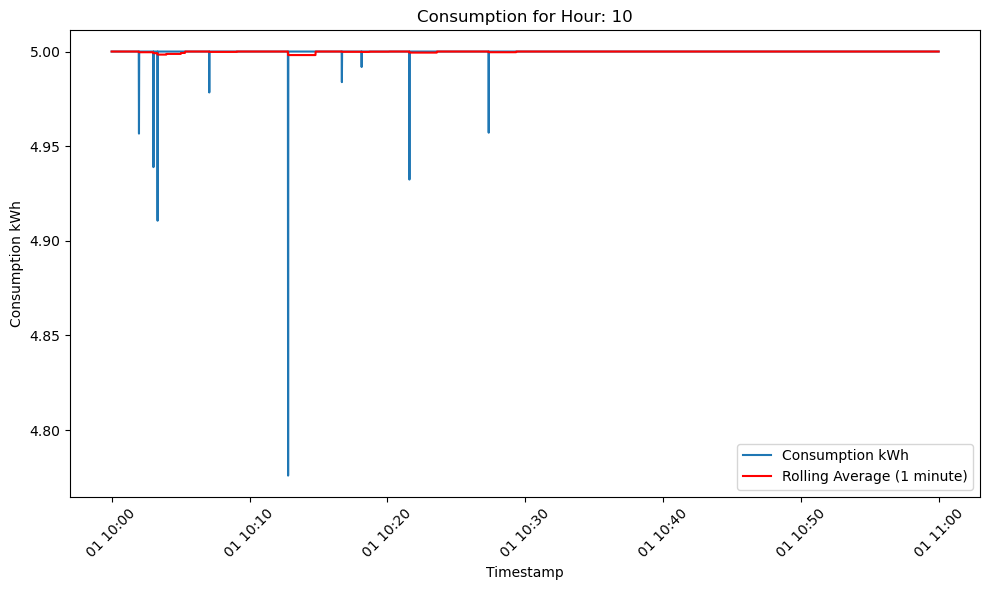

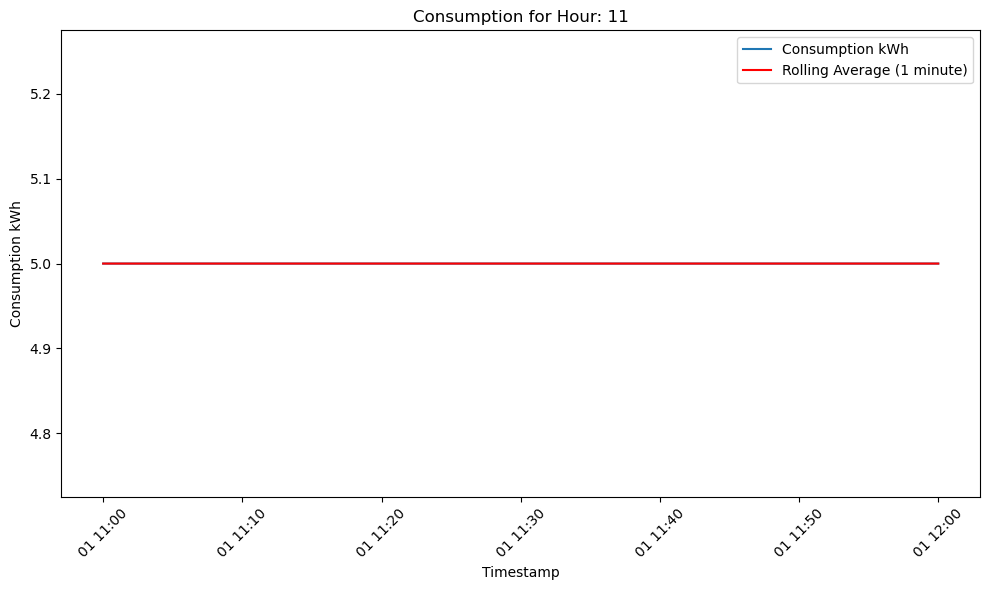

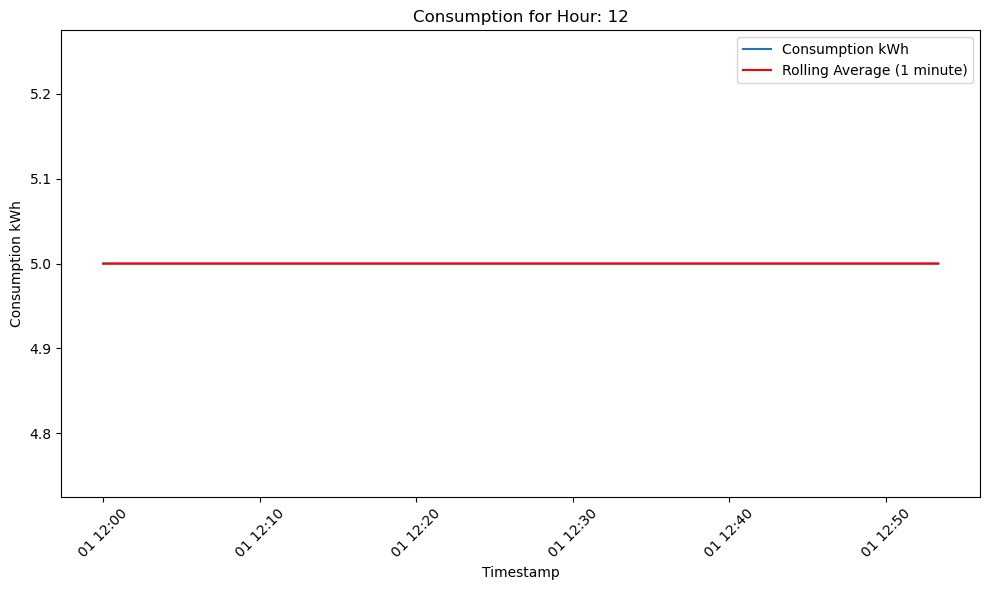

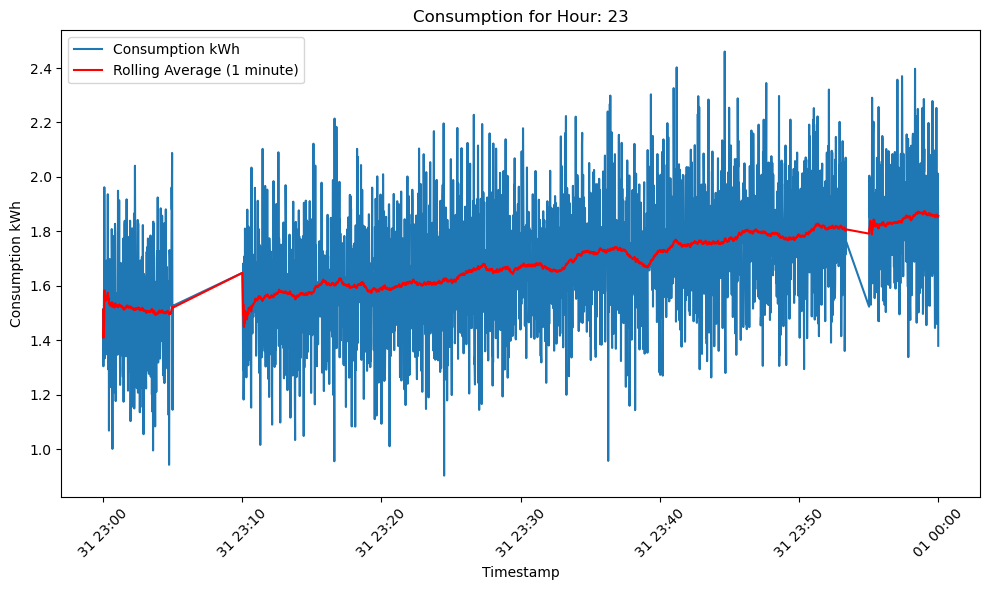

In [15]:
for hour, group in grouped_data:
    # Set the timestamp as the index
    group = group.set_index('timestamp')

    # Calculate the rolling average over a minute
    # Assuming 'consumption_kwh' is recorded every second
    group['rolling_avg'] = group['consumption_kwh'].rolling('120s').mean()

    # Reset index to use timestamp in the plot
    group = group.reset_index()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(group['timestamp'], group['consumption_kwh'], label='Consumption kWh')
    plt.plot(group['timestamp'], group['rolling_avg'], label='Rolling Average (1 minute)', color='red')
    plt.title(f"Consumption for Hour: {hour}")
    plt.xlabel("Timestamp")
    plt.ylabel("Consumption kWh")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


The above plots show the power consumption rolling avg over 120 seconds for each hour in our sample dataset. which indicates similar behaviour as for the whole 14 hours.